In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import numpy as np
from tqdm import tqdm

p = 10
k = 2
d = 3
gamma = 5e-2
noise = 1e-3

log_time = 4
dt = 1e-3
activation = 'erf'

store_path = f'computation-database/classic-limit/{activation}'
ic_string = 'classic-limit'

In [35]:
from committee_learning.initial_conditions import RandomNormalInitialConditions
from committee_learning.simulation import Simulation
from committee_learning.ode import ErfActivationODE, SquaredActivationODE
from committee_learning.result import SimulationResult, FullODEResult

ic = RandomNormalInitialConditions(p, k, d, seed = 3, orth_teacher=True)


sim = Simulation(
  d=d,
  p=p,
  k=k,
  noise=noise,
  Wt=ic.Wt,
  gamma=gamma,
  activation=activation,
  W0=ic.W0
)

simr = SimulationResult(ic_string, id = 2)


if activation == 'erf':
  FullODE = ErfActivationODE
elif activation == 'square':
  FullODE = SquaredActivationODE

ode = FullODE(ic.P,ic.Q,ic.M,dt, gamma_over_p = gamma/p, noise = noise)
oder = FullODEResult(ic_string, id = 2)


In [36]:
simr.from_file_or_run(sim,log_time+np.log10(d*p/gamma),path=store_path + 'sim/')

100%|██████████| 5000000/5000000 [27:25<00:00, 3038.92it/s]


In [37]:
oder.from_file_or_run(ode,log_time,path=store_path+'ode/')

100%|██████████| 9000000/9000000 [04:10<00:00, 35874.97it/s]


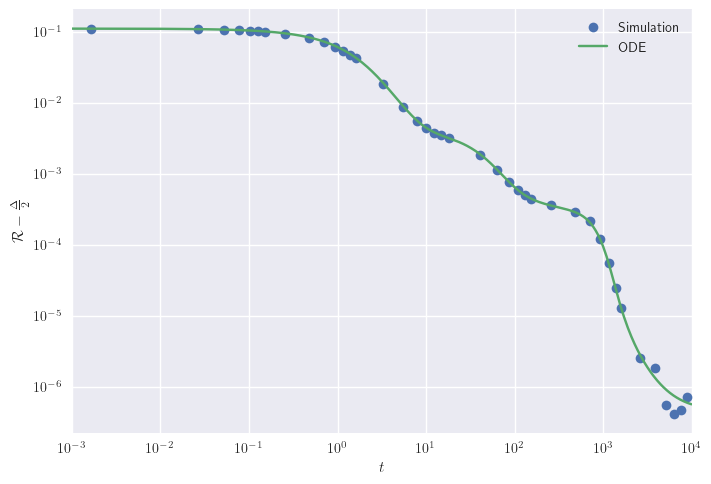

In [38]:
from committee_learning.utilities import plot_style

import matplotlib.pyplot as plt

with plot_style():
  fig, ax = plt.subplots()
  # ax.set_title(f'$\\gamma\\to0$ ($\\gamma=\\num{{{gamma}}}$ for the simulation)')
  ax.set_xlim(dt,10**(log_time))
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$\mathcal{R}-\frac{\Delta}{2}$')

  ax.plot(np.array(
    simr.steps[::15])*(gamma/(p*d)),
    np.array(simr.risks[::15]),# + noise,
    ls='',
    label=f'Simulation',
    marker='o'
  )
  ax.plot(np.array(oder.times), np.array(oder.risks), label='ODE')
  ax.legend()
  # fig.savefig(f'figures/classic_limit-k{k}_p{p}_d{d}_gamma{gamma:.4f}_noise{noise}.pdf', bbox_inches='tight')
  plt.show()


In [68]:
from matplotlib import animation
from IPython import display
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def norm_M(Q, P):
  npQ = np.array(Q)
  npP = np.array(P)
  return np.sqrt(np.einsum('tj,r->tjr', np.diagonal(npQ, axis1=1, axis2=2), np.diagonal(npP, axis1=0, axis2=1)))

Msim = np.array(simr.Ms)/norm_M(simr.Qs, simr.P)
Mode = np.array(oder.Ms)/norm_M(oder.Qs, oder.P)

print(Mode.shape[0])
with plot_style(style='classic'):
  fig, ax = plt.subplots(figsize=(5,5))
  ax.set_xlim(-1,1)
  ax.set_ylim(-1,1)
  ax.axvline(0.,0.,2., ls='-.', c='red')
  ax.axhline(0.,0.,2., ls='-.', c='red')
  ax.set_xlabel(r'$M_{j1}/\sqrt{Q_{jj}P_{11}}$')
  ax.set_ylabel(r'$M_{j2}/\sqrt{Q_{jj}P_{22}}$')
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.plot(1./np.sqrt(2), 1./np.sqrt(2), marker='o', c='yellow', ms = 15.)
  ax.plot(1, 0, marker='s', c='red', ms = 15.)
  ax.plot(0, 1, marker='s', c='red', ms = 15.)
  risk_ax = inset_axes(ax, width='35%', height='32%', loc = 3)
  risk_ax.set_xscale('log')
  risk_ax.set_yscale('log')
  risk_ax.set_xlabel('$t$', labelpad= -18.)
  risk_ax.set_ylabel(r'$\mathcal{R}-\frac{\Delta}{2}$', labelpad= -27.)
  risk_ax.set_yticklabels([])
  risk_ax.set_xticklabels([])
  risk_ax.set_xlim(5e-2,10**4)
  risk_ax.set_ylim(5e-7,.15)

  sim_particles = [ax.plot([], [])[0] for j in range(p)]
  ode_particles = [ax.plot([], [])[0] for j in range(p)]
  risk_plot = risk_ax.plot([], [])[0]
  timestamp = ax.text(-.9, .9, '', fontsize=15)

  def init():
    for sp in sim_particles:
      sp.set_data([],[])
    for op in ode_particles:
      op.set_data([],[])
    risk_plot.set_data([],[])
    timestamp.set_text(f'$t={oder.times[0]}$')
    return (*sim_particles, *ode_particles, risk_plot, timestamp)

  def animate(frame_number):
    for j,op in enumerate(ode_particles):
      op.set_data(Mode[:frame_number,j,0],Mode[:frame_number,j,1])

    risk_plot.set_data(oder.times[:frame_number], oder.risks[:frame_number])
    timestamp.set_text(f'$t={oder.times[frame_number]:.2f}$')
    return (*sim_particles, *ode_particles, risk_plot, timestamp)

  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=range(0,Mode.shape[0], 10), interval=150, blit=True)

  # To save the animation as a gif
  writer = animation.PillowWriter(fps=15, bitrate=1800)
  anim.save('figures/scatter.gif', writer=writer)

  video = anim.to_html5_video()
  html = display.HTML(video)
  display.display(html)


600
